<a href="https://colab.research.google.com/github/andyharless/covid19states/blob/master/covid_pos_rate_compare_update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
# Data from https://covidtracking.com
url = 'https://docs.google.com/spreadsheets/d/18oVRrHj3c183mHmq3m89_163yuYltLNlOmPerQ18E8w'

In [0]:
# Get data as a spreadsheet workbook
wb = gc.open_by_url(url)

In [0]:
# Get the sheet with daily data by state
data = wb.worksheet('States daily 4 pm ET').get_all_values()

In [6]:
# Convert to a Pandas DataFrame
full_df = pd.DataFrame(data)
full_df.head()

,0,1,2,3,4,5,6,7
0,Date,State,Positive,Negative,Pending,Hospitalized,Death,Total
1,20200401,AK,133,"4,470",,9,3,"4,603"
2,20200401,AL,"1,077","6,697",,,26,"7,774"
3,20200401,AR,584,"7,354",,90,10,"7,938"
4,20200401,AS,0,20,6,,0,26


In [0]:
# Use the first row of data as column names
def set_first_row_as_header(df):
  new_header = df.iloc[0] # Grab the first row for the header
  df = df[1:]             # Take the data less the header row
  df.columns = new_header # Set the header row as the df header
  return(df)

In [0]:
# Convert data to the appropriate types
def convert_dtypes(df):
  for c in df.columns:
    if c=='Date':                   # 'Date' is a date
      df[c] = pd.to_datetime(df[c])  
    elif c=='State':                # 'State' is a string (default, so no action)
      pass                           
    else:                           # The rest are numeric, need to remove commas
      df[c] = pd.to_numeric(df[c].str.replace(',',''))
  return(df)

In [0]:
# Proccess the data frames and calculate positive rates
full_df = set_first_row_as_header(full_df)
full_df = convert_dtypes(full_df)
full_df['posrate'] = full_df.Positive / (full_df.Positive+full_df.Negative.fillna(0))

In [10]:
# Find states with more than 1000 confirmed cases,
#   arranged in descending order of number of cases
current = full_df.sort_values(['Date', 'Positive'], ascending=False).head(50)
states = current[current.Positive>1000].State.values
states

array(['NY', 'NJ', 'MI', 'CA', 'MA', 'IL', 'FL', 'LA', 'PA', 'WA', 'GA',
       'TX', 'CT', 'CO', 'TN', 'IN', 'OH', 'MD', 'NC', 'MO', 'WI', 'VA',
       'AZ', 'SC', 'NV', 'AL', 'MS', 'UT'], dtype=object)

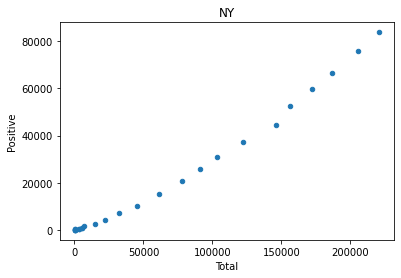

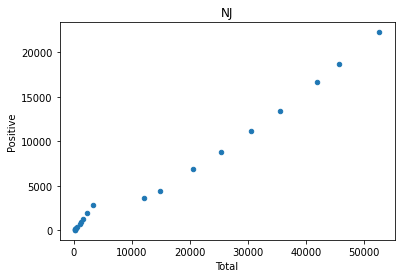

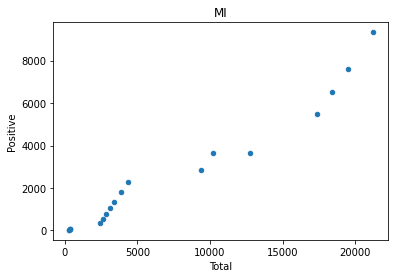

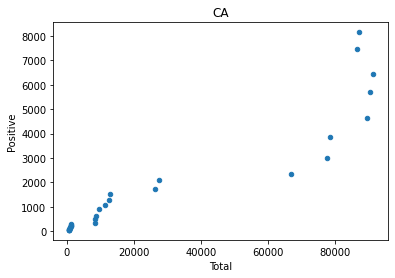

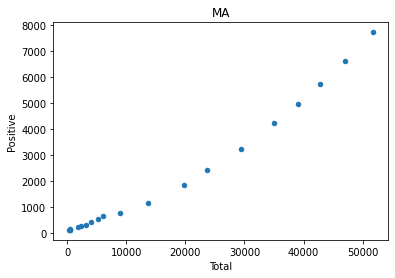

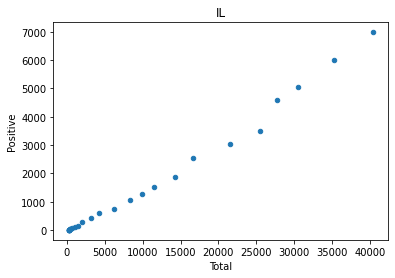

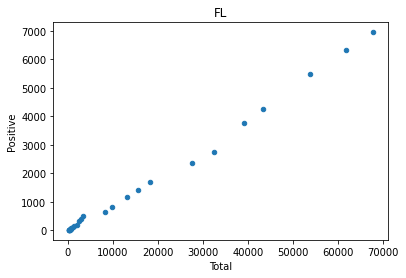

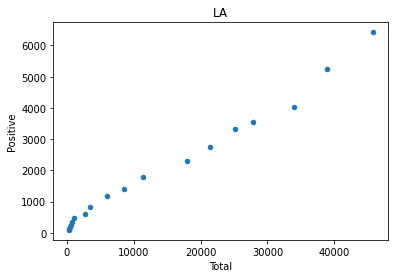

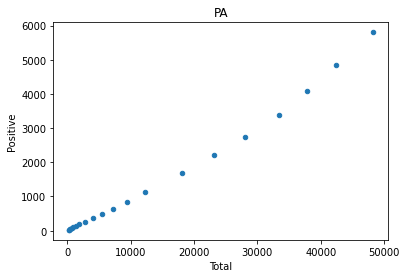

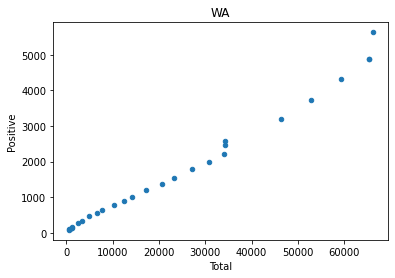

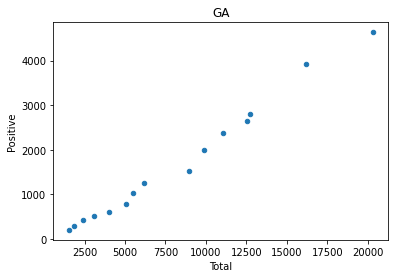

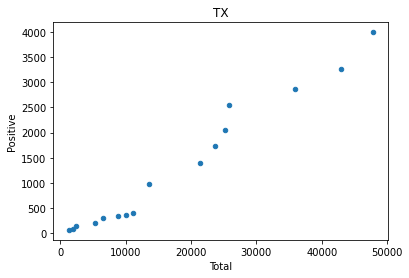

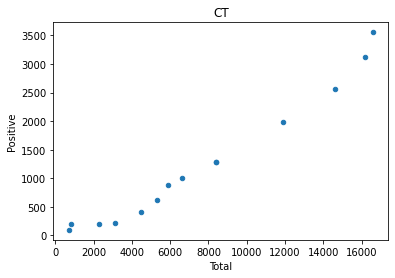

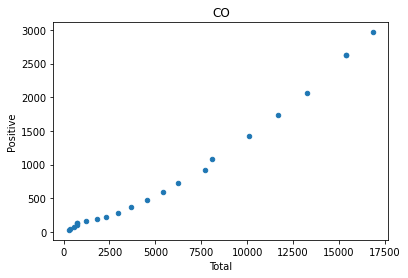

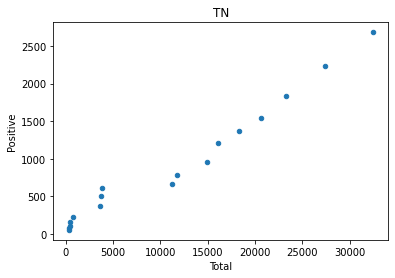

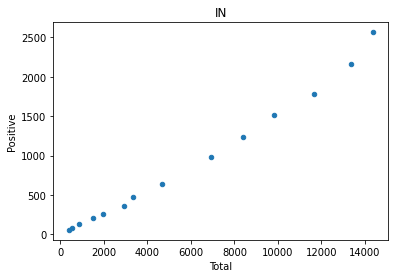

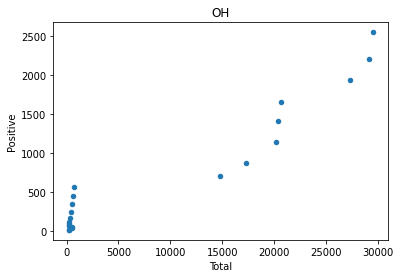

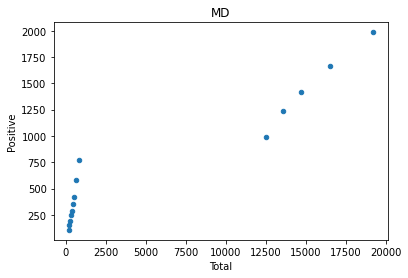

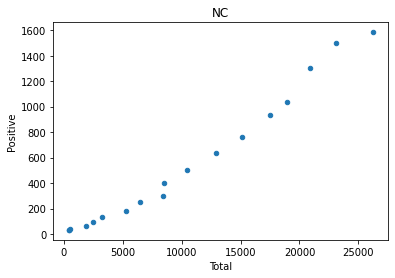

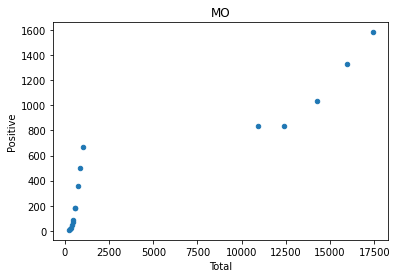

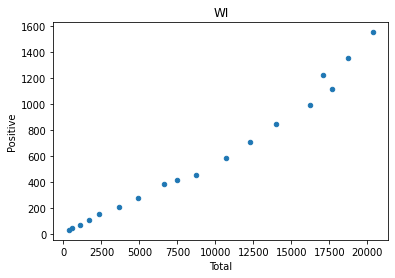

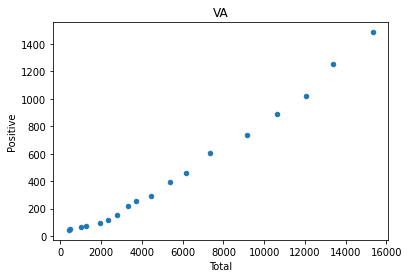

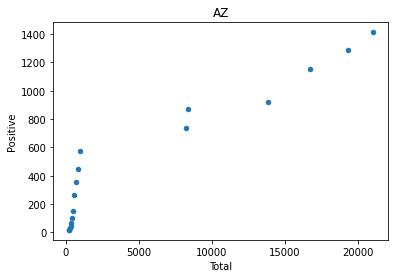

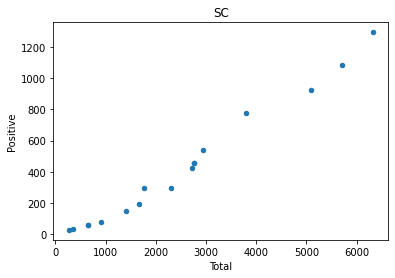

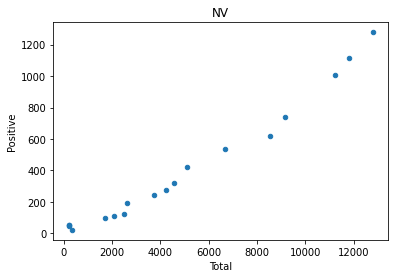

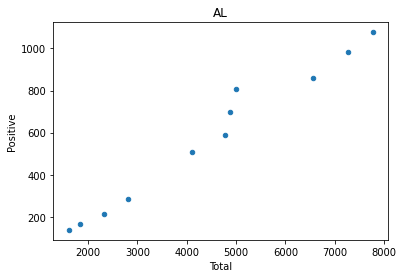

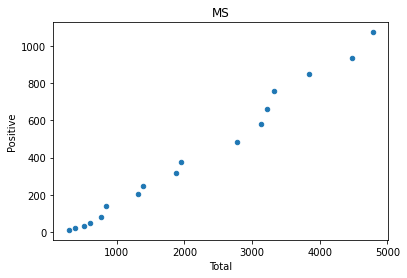

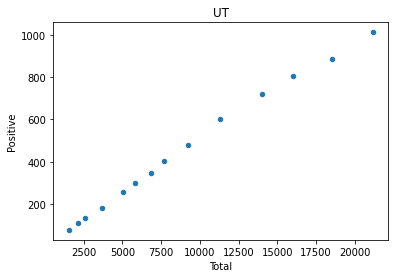

In [11]:
# Scatterplot  "Number of positive tests (confirmed cases)" 
#          vs. "Total number of cumulative tests"  (by state)

# We hope (but thus far do not find) that these plots will eventually start
#   to look like concave functions.  In other words, states should be testing
#   more and more people and hoping that, as testing is broadened, they find
#   a smaller proportion of infections among those tested.

for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Total','Positive']].plot(kind='scatter', x='Total', y='Positive', title=state)
  plt.show()

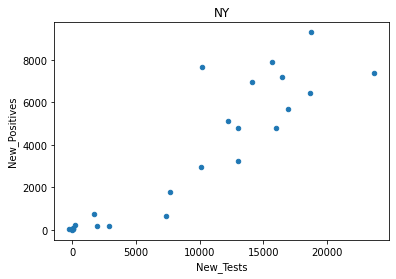

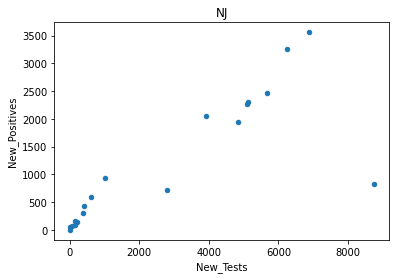

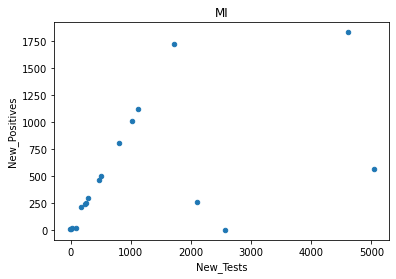

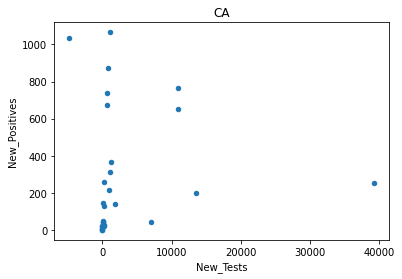

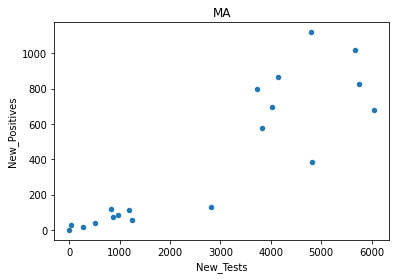

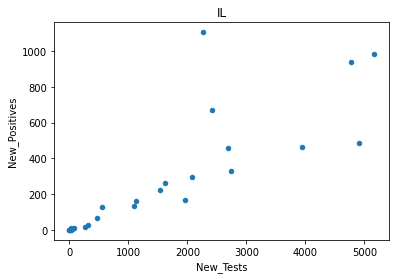

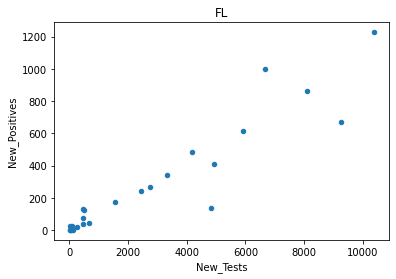

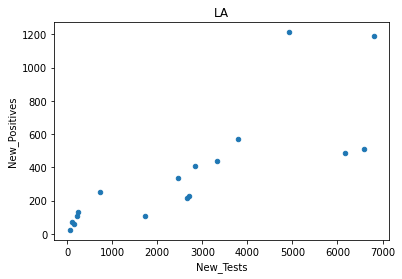

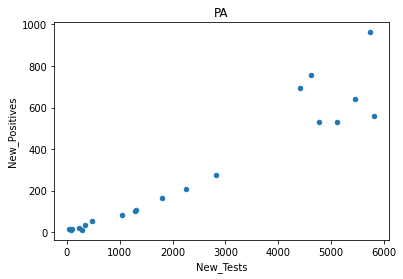

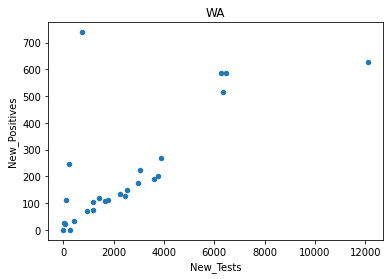

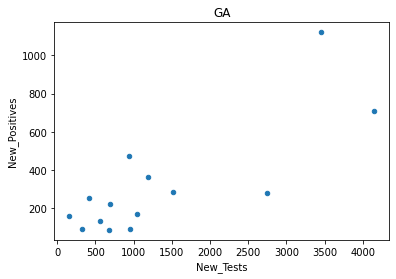

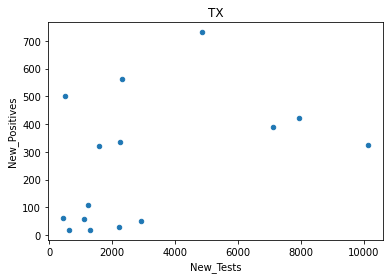

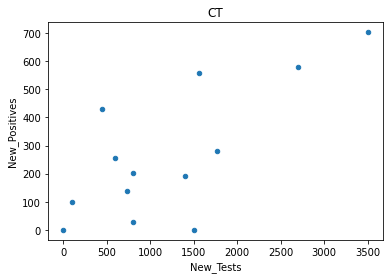

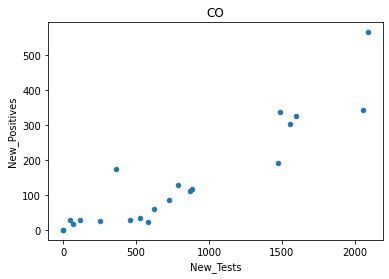

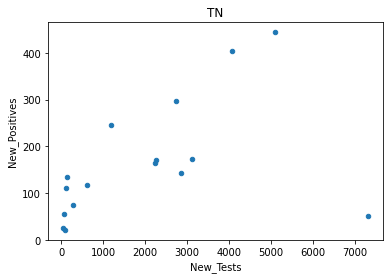

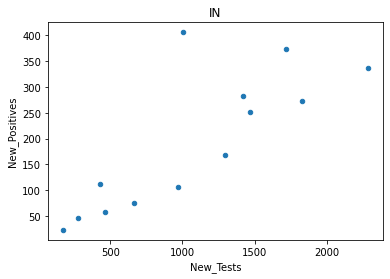

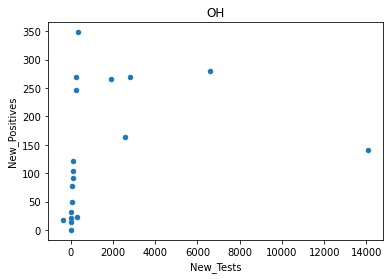

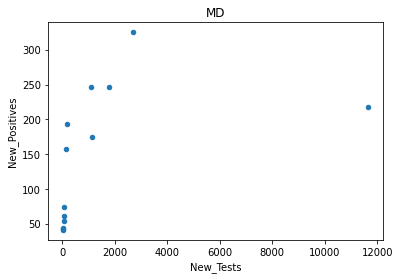

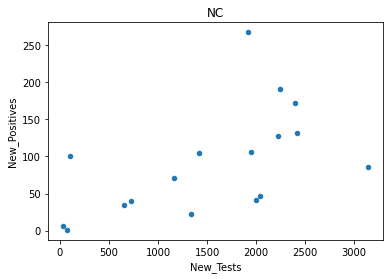

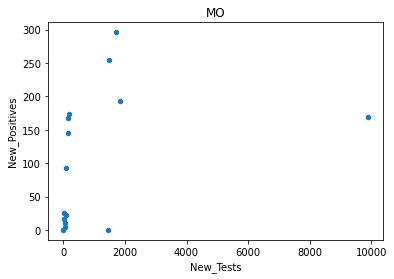

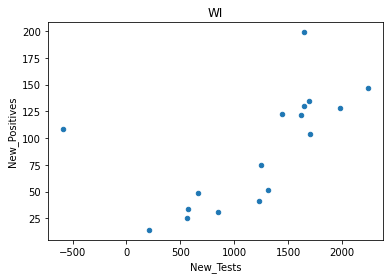

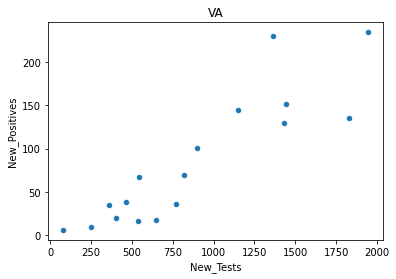

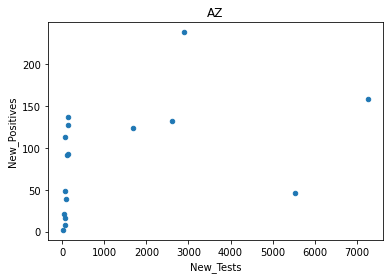

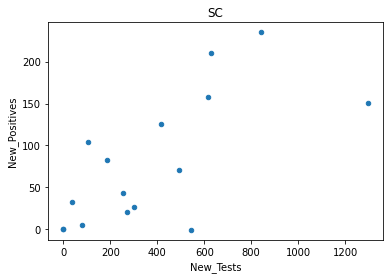

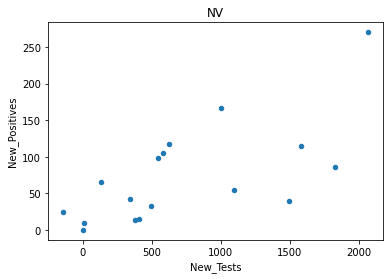

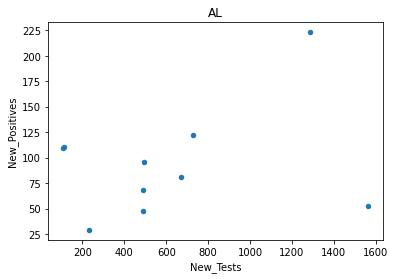

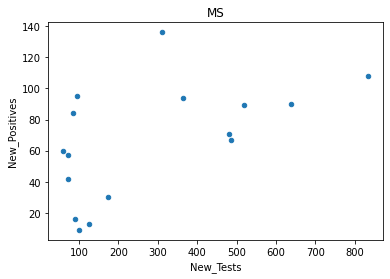

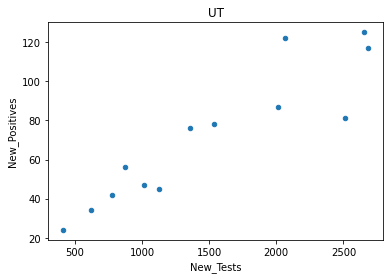

In [12]:
# Scatterplot  "Number of NEW positive tests (latest confirmed cases)" 
#          vs. "Total number of NEW tests"   (by state)

# We hope (but thus far do not find) that these will eventually flatten out.
#   Again, states should be testing more and more people and hoping that, 
#   as testing is broadened, they find a smaller proportion test positive.

for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Tests'] = -df['Total'].diff()
  df['New_Positives'] = -df['Positive'].diff()
  df[df.Total>200][['New_Tests','New_Positives']].plot(kind='scatter', 
                                                       x='New_Tests', 
                                                       y='New_Positives', 
                                                       title=state)
  plt.show()

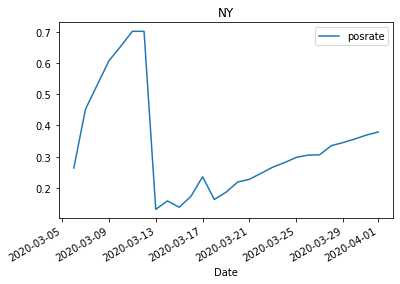

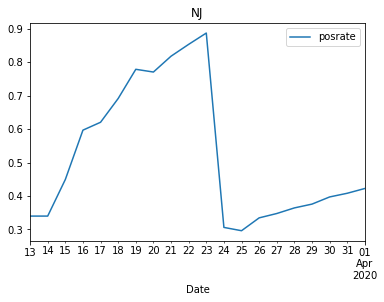

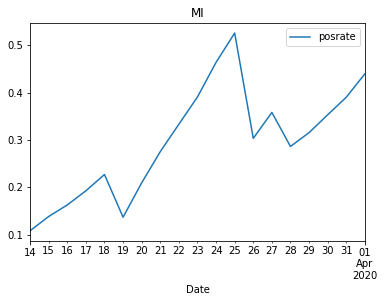

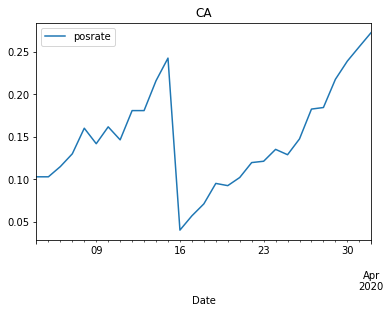

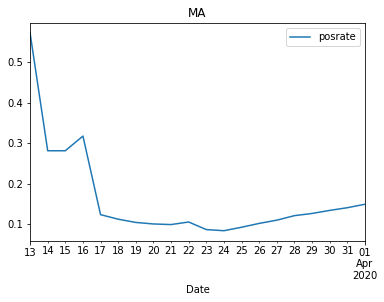

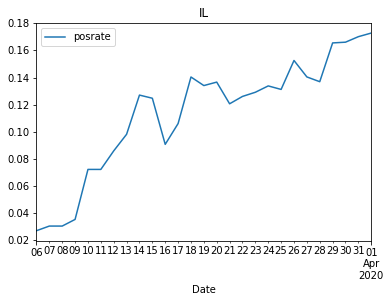

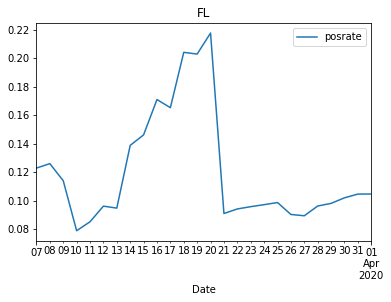

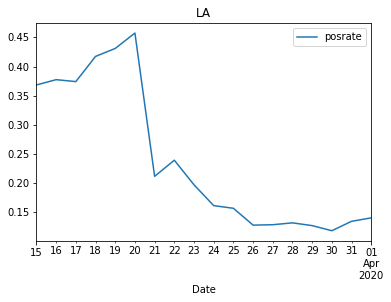

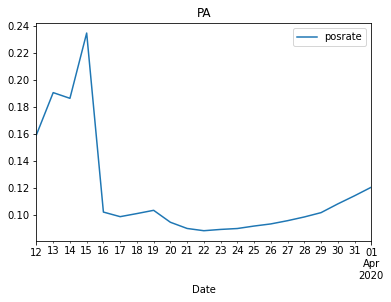

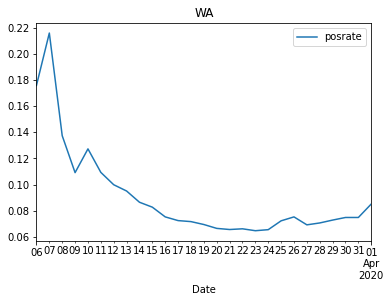

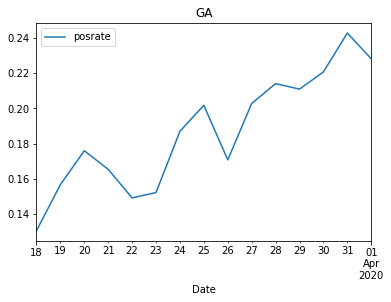

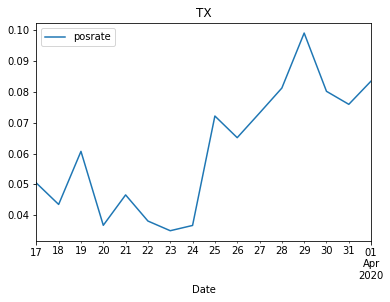

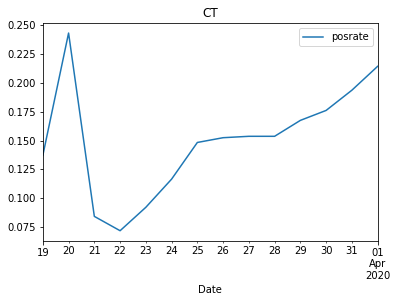

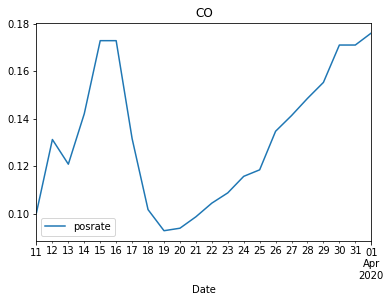

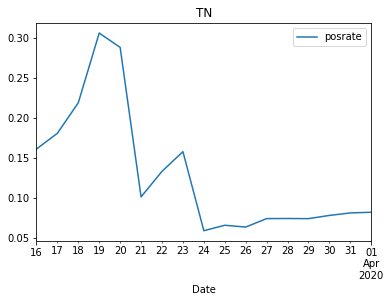

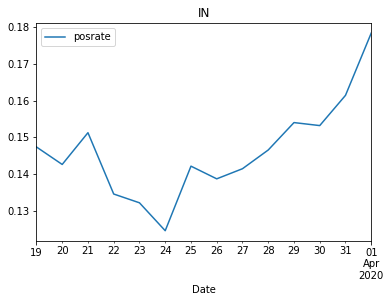

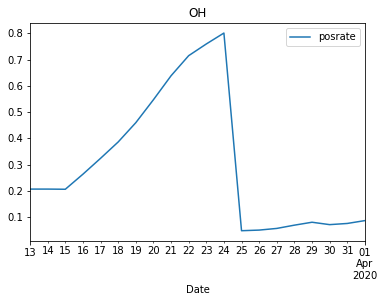

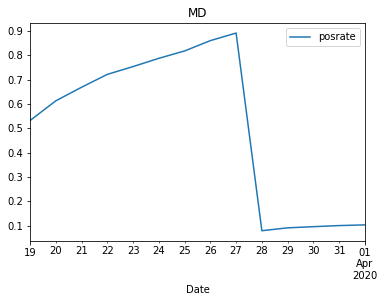

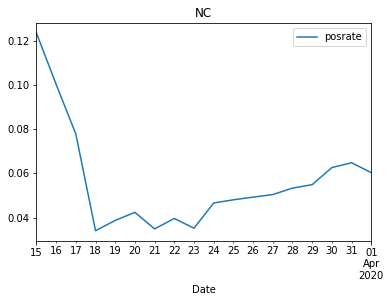

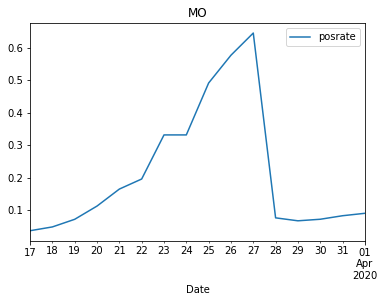

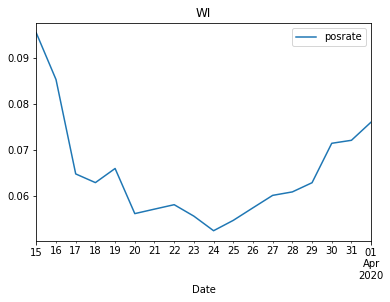

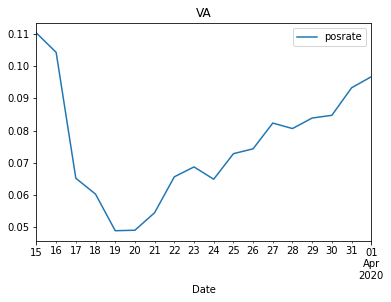

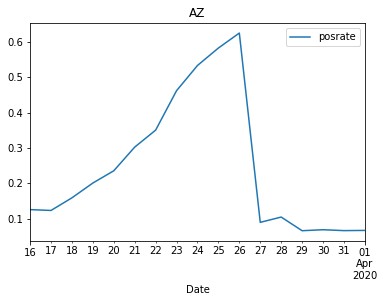

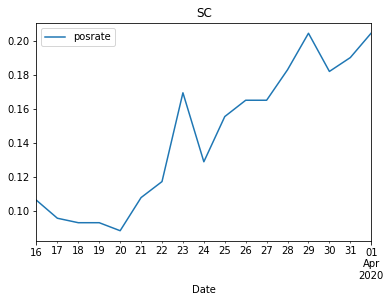

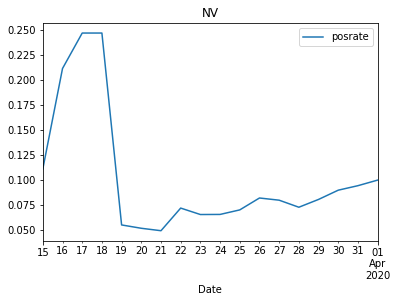

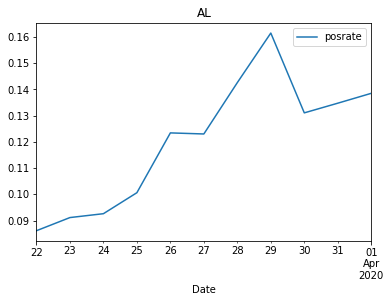

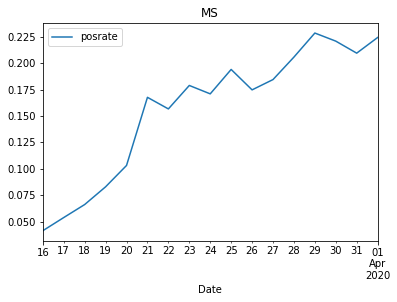

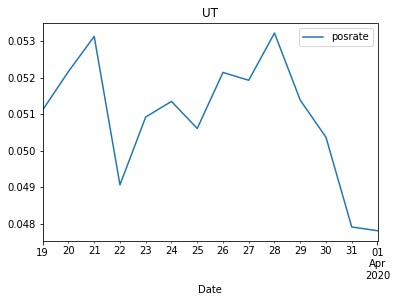

In [13]:
# Plot time series of fraction of tests that are positive (by state)
for state in states:
  df = full_df[full_df.State==state]
  df[df.Total>200][['Date','posrate']].set_index('Date').plot(y='posrate', title=state)
  plt.show()

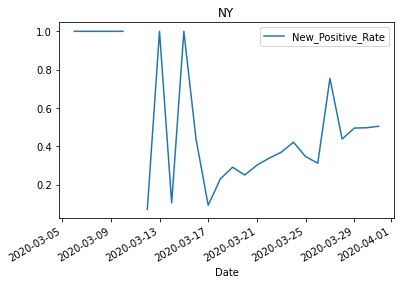

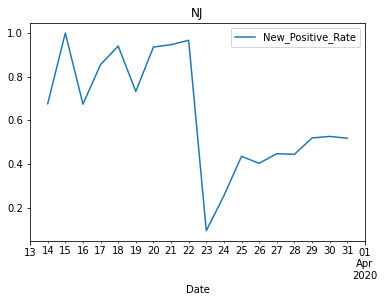

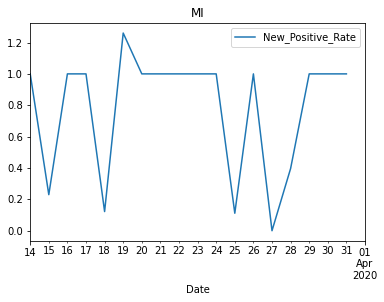

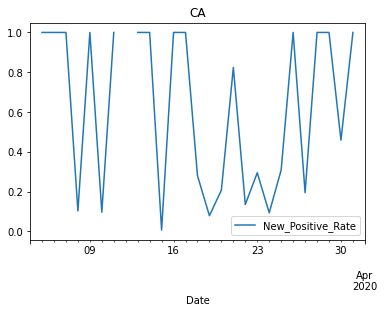

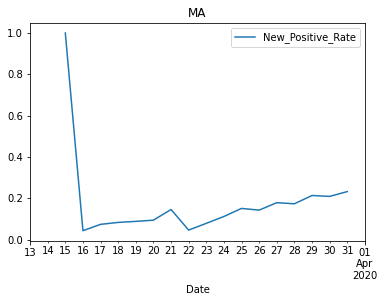

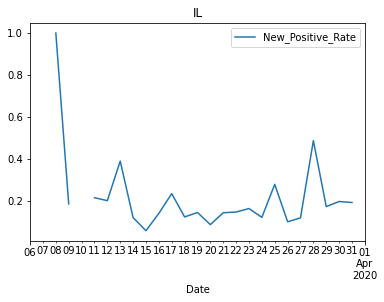

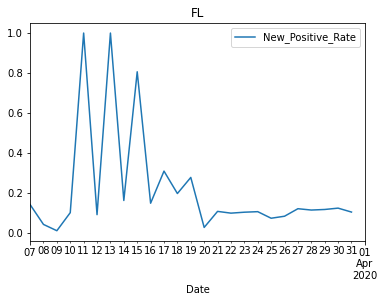

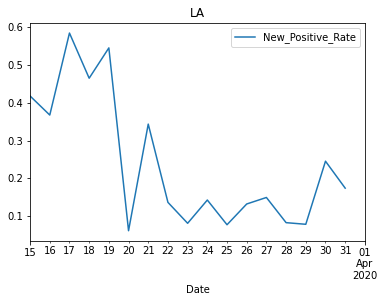

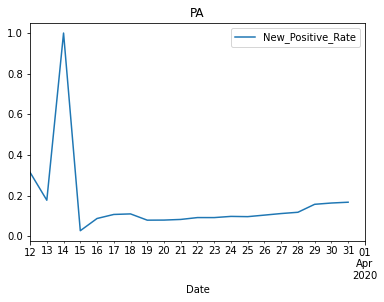

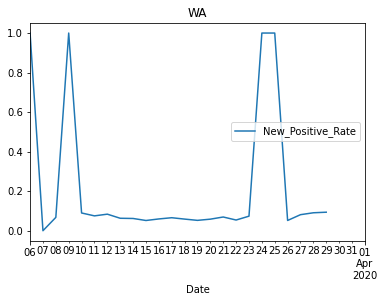

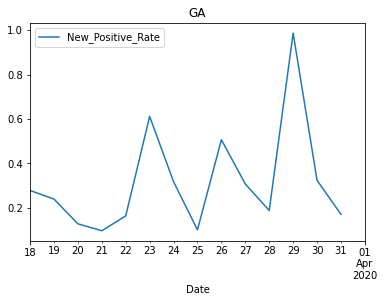

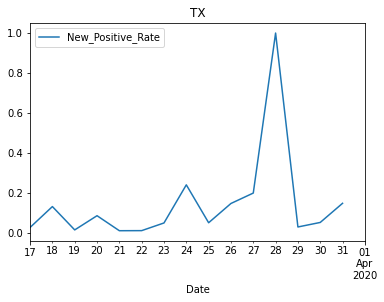

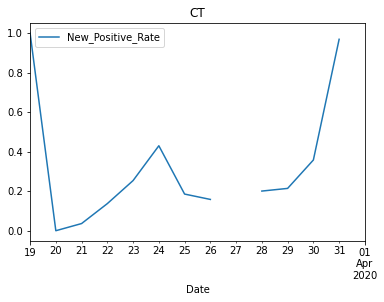

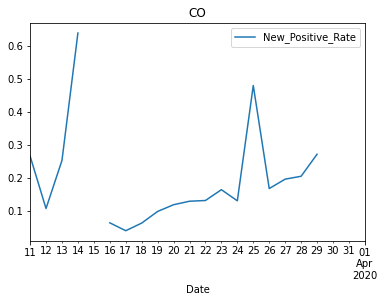

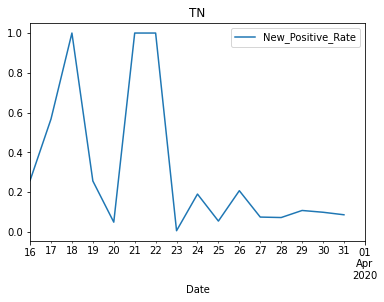

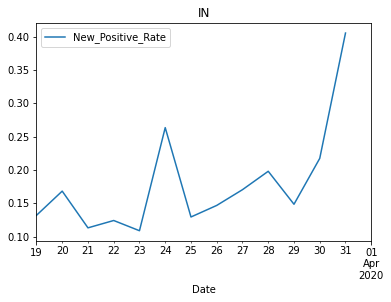

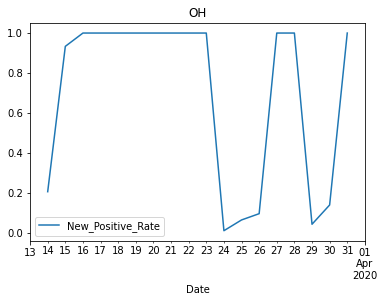

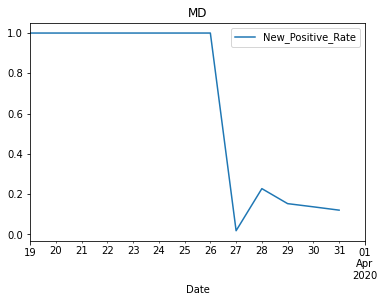

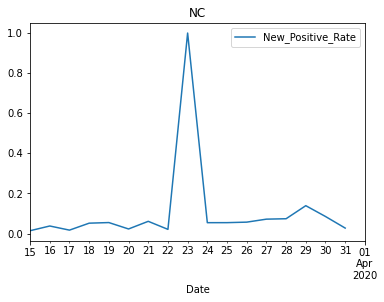

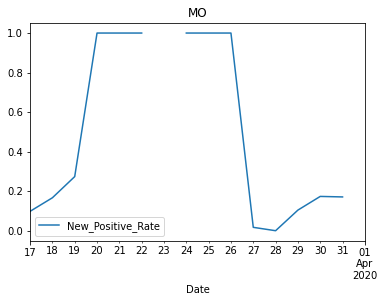

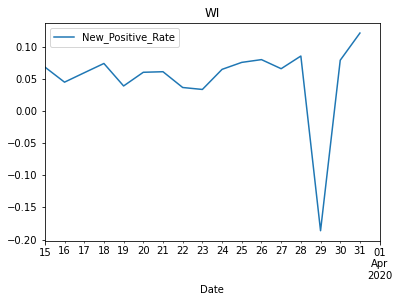

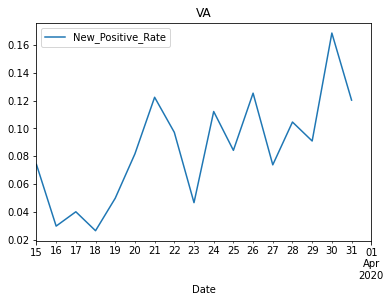

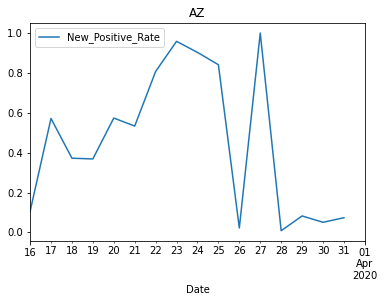

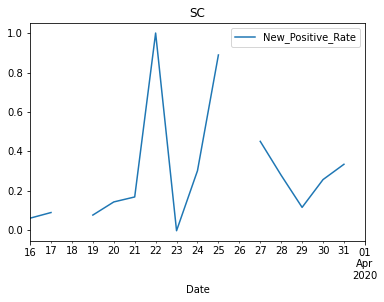

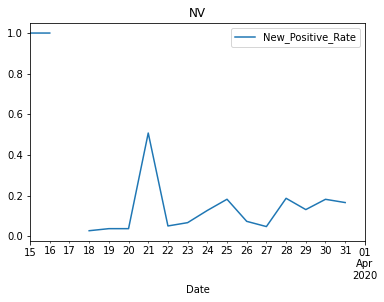

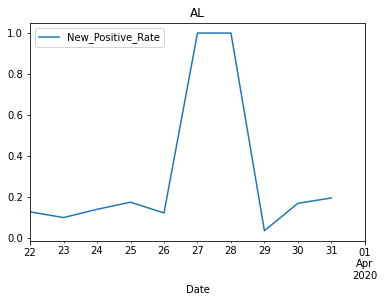

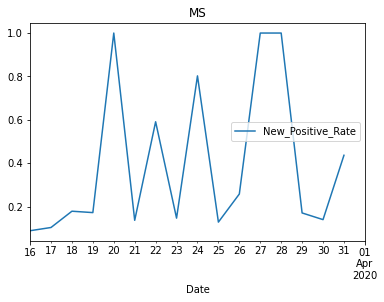

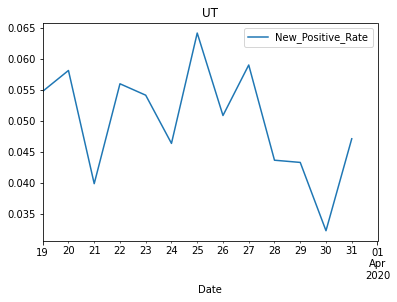

In [14]:
# Plot time series of fraction of NEW tests that are positive, by state
for state in states:
  df = full_df[full_df.State==state].copy()
  df['New_Positives'] = -df['Positive'].diff()
  df['New_Negatives'] = -df['Negative'].diff()
  df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
  df[df.Total>200][['Date',
                    'New_Positive_Rate']].set_index('Date').plot(y='New_Positive_Rate', 
                                                                 title=state)
  plt.show()

In [15]:
# Show mean fraction of cumulative positives (over time) by state, 
#   along with standard deviation
#   (These are sorted by increasing standard deviation, so the top of the table
#    represents states that have had the most consistent fraction of positive tests)
# It's noteworthy that most of the standard deviations are small compared to the means
#    and that the means vary quite a lot by state.
# So within-state results (for positive rate) are typically consistent over time
#    whereas positive rate varies a lot from one state to another
df = full_df[full_df.Date>'2020-03-16'][['Date', 'posrate', 'State']]
by_state = df[df.State.isin(states)].groupby('State')
by_state.posrate.agg(['mean', 'std']).sort_values('std')

,mean,std
State,,
WA,0.071021,0.005192
WI,0.061882,0.006794
PA,0.098434,0.009329
NC,0.049567,0.012396
VA,0.071608,0.014623
MA,0.112365,0.019023
IL,0.141431,0.019071
TX,0.061151,0.020405
IN,0.152443,0.021013


In [16]:
# Show mean fraction of DAILY positives (over time) by state, 
#   along with standard deviation
#   (These are sorted by increasing standard deviation, so the top of the table
#    represents states that have had the most consistent fraction of positive tests)
# These are less dramatic than the previous table, but still tend to show
#    that within-state results are typically consistent over time
#    whereas positive rate varies a lot from one state to another
df = full_df.sort_values(['State','Date']).copy()
df['New_Positives'] = df['Positive'].diff()  # Kluge because it's wrong when the state changes
df['New_Negatives'] = df['Negative'].diff()  #   but OK because we use only after 3/16
df['New_Positive_Rate'] = df.New_Positives / (df.New_Positives+df.New_Negatives.fillna(0))
df = df[df.Date>'2020-03-16'][['Date', 'New_Positive_Rate', 'State']]
by_state = df[df.State.isin(states)].groupby('State')
by_state.New_Positive_Rate.agg(['mean', 'std']).sort_values('std')

,mean,std
State,,
PA,0.109092,0.029012
VA,0.085894,0.039990
MA,0.129496,0.060406
WI,0.049507,0.066569
FL,0.133075,0.072241
IN,0.186496,0.084807
IL,0.177265,0.096191
CO,0.165353,0.108101
NY,0.379885,0.149446
